## 드론허가구역 시각화

### 라이브러리 임포트

In [46]:
import os               # 운영체제 관련 기능(파일 경로 처리나 디렉터리 작업 위해)
import ast              # 문자열로 표현된 파이썬 리터럴(예: 리스트, 튜플 등)을 안전하게 실제 객체로 변환하기 위해 사용
                        # -> NE_table의 NE 열에서 다각형 좌표 데이터를 문자열에서 리스트로 변환할 때 ast.literal_eval()로 사용
import pandas as pd
import folium
import base64           #matplotlib로 생성한 그래프 이미지를 base64 형식으로 인코딩하여 HTML 팝업에 삽입하기 위해 사용
from io import BytesIO  #메모리 내에서 바이너리 데이터를 저장하는 스트림 객체를 생성
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json             #JSON 형식의 데이터를 파싱하거나 생성할 때 사용(여기서 직접적인 사용하지는 X)

### 경고창 무시 및 글씨체 설정

In [47]:
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'Malgun Gothic'

### 1. csv 파일 불러오기

In [48]:
# csv파일 경로 설정
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, '데이터')
circle_table_path = os.path.join(data_dir, r'전처리\circle_table.csv')
NE_table_path = os.path.join(data_dir, r'전처리\NE_table.csv')
weather_yn_df_path = os.path.join(data_dir, r'전처리\weather_yn_df.csv')
print(data_dir)

C:\Users\KSH\Documents\크롤링 프로젝트\프로젝트 4조\프로젝트 4조\데이터


In [49]:
# =============================================================================
# CSV 파일 불러오기
# =============================================================================
# circle_table: 원형 비행구역 정보 (위치, 위도, 경도, 반경 등)
# NE_table: 다각형 비행구역 정보 (위치, 다각형 좌표 NE)
# weather_yn_df: 각 지역의 월별 비행 가능 일수 (stnNm, yyyymm, yn_month 등)

circle_table = pd.read_csv(circle_table_path, encoding='cp949')
NE_table = pd.read_csv(NE_table_path, encoding='cp949')
weather_yn_df = pd.read_csv(weather_yn_df_path, encoding='cp949')

### 2. 지도 내 각 지역별 삽입 그래프 만들기 

In [50]:
# =============================================================================
# 그래프 생성 함수: 각 지역의 월별 비행 가능 일수를 막대그래프로 생성
# =============================================================================
# graph_cache를 사용하여 이미 생성된 그래프를 재사용 (성능 최적화)
graph_cache = {}

def create_graph(region_name, data):
    """
    region_name: 해당 지역명 (stnNm)
    data: weather_yn_df에서 해당 지역에 해당하는 행들
    
    - 데이터가 있으면 막대그래프를 생성:
        - 막대 색상: 7일 이하 → 빨강, 23일 이상 → 초록, 나머지 → 스카이블루
        - x축: 월(yyyymm), y축: 비행 가능 일수(yn_month)
        - 범례 추가 (비추천/보통/추천)
    - 생성된 그래프 이미지는 base64로 인코딩되어 반환됨.
    - 이미 생성된 그래프는 캐싱되어 재사용됨.
    """
    if region_name in graph_cache:
        return graph_cache[region_name]
    
    # 그래프 생성 (데이터가 비어있어도 막대그래프 로직을 실행합니다)
    fig, ax = plt.subplots()
    bar_colors = []
    for val in data['yn_month']:
        if val <= 16.83:             # quantile(0.56)
            bar_colors.append('red')
        elif val >= 22.63:           # quantile(0.75)
            bar_colors.append('green')
        else:
            bar_colors.append('skyblue')
    
    ax.bar(data['yyyymm'], data['yn_month'], color=bar_colors)
    ax.set_ylabel("비행 가능 일수")
    ax.set_title(f"{region_name}의 월별 비행 가능 일수")
    month_labels = ['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
        # x축 레이블을 월 이름으로 설정
    ax.set_xticks(range(0,12))  # 1부터 12까지의 ticks
    ax.set_xticklabels(month_labels, fontsize=10)  # '1월', '2월', ...으로 설정
    
    # 범례 설정
    red_patch = mpatches.Patch(color='red', label='비추천')
    skyblue_patch = mpatches.Patch(color='skyblue', label='보통')
    green_patch = mpatches.Patch(color='green', label='추천')
    ax.legend(handles=[red_patch, skyblue_patch, green_patch])
    
    # 그래프 이미지를 메모리에 저장한 후 base64 인코딩
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    encoded_image = base64.b64encode(buffer.read()).decode()
    plt.close(fig)
    
    graph_cache[region_name] = encoded_image
    return encoded_image

### 3. folium 지도 생성

In [51]:
# =============================================================================
# Folium 지도 생성
# =============================================================================
# 초기 지도 중심 좌표: 기본값 [37.0, 127.0] 설정
map_center = [37.0, 127.0]
if not circle_table.empty and pd.notna(circle_table.iloc[0]['위도']) and pd.notna(circle_table.iloc[0]['경도']):
    try:
        map_center = [float(circle_table.iloc[0]['위도']), float(circle_table.iloc[0]['경도'])]
    except:
        pass

m = folium.Map(location=map_center, zoom_start=7)

### 3.1 지도 내 드론비행구역 표시하기

#### 3.1.1) Circle 지역 그리기 함수

In [52]:
# =============================================================================
# Circle 마커 추가: circle_table의 점 정보를 기반으로 파란색 원을 지도에 표시
# =============================================================================
def add_circle_markers(map_obj, circle_table, weather_yn_df):
    for _, row in circle_table.iterrows():
        # region_name: 전처리된 지역명 (stnNm)
        region_name = row['지역']
        # weather_yn_df에서 해당 지역에 대한 데이터 (stnNm 기준)
        matched_region_data = weather_yn_df[weather_yn_df['stnNm'] == region_name]
        # 해당 지역의 막대그래프 이미지 생성
        graph_img = create_graph(region_name, matched_region_data)
        popup_html = f'<b>{region_name}</b><br><img src="data:image/png;base64,{graph_img}" width="300">'
        
        try:
            if pd.notna(row['위도']) and pd.notna(row['경도']):
                folium.Circle(
                    location=[float(row['위도']), float(row['경도'])],
                    radius=float(row['반경'])*1000 if pd.notna(row['반경']) else 500,  # 반경은 km 단위이므로 m로 변환
                    color="blue",
                    fill=True,
                    fill_color="skyblue",
                    fill_opacity=0.3,
                    popup=folium.Popup(popup_html, max_width=400)
                ).add_to(map_obj)
        except Exception as e:
            print(f"Circle 마커 추가 실패: {e}")



#### 3.1.2) Polygon 지역 그리기 함수

In [53]:
# =============================================================================
# Polygon 마커 추가: NE_table의 다각형 데이터를 기반으로 파란색 다각형을 지도에 표시
# =============================================================================
def add_polygon_markers(map_obj, NE_table, weather_yn_df):
    for _, row in NE_table.iterrows():
        # region_name: 전처리된 지역명
        region_name = row['지역']
        
        # NE 컬럼이 존재하는 경우 처리
        if pd.notna(row['NE']) and row['NE'].strip() != "":
            try:
                ne_data = row['NE']
                # NE 데이터가 문자열이면 리스트로 변환
                ne_list = ast.literal_eval(ne_data) if isinstance(ne_data, str) else ne_data
                # 모든 좌표를 float형태의 리스트로 변환
                ne_list = [[float(lat), float(lon)] for lat, lon in ne_list]
                
                matched_region_data = weather_yn_df[weather_yn_df['stnNm'] == region_name]
                graph_img = create_graph(region_name, matched_region_data)
                popup_html = f'<b>{region_name}</b><br><img src="data:image/png;base64,{graph_img}" width="300">'
                
                folium.Polygon(
                    locations=ne_list,
                    color="blue",
                    fill=True,
                    fill_color="skyblue",
                    fill_opacity=0.3,
                    popup=folium.Popup(popup_html, max_width=400)
                ).add_to(map_obj)
            except Exception as e:
                print(f"Polygon 마커 추가 실패: {e}")


### 3.1.3) folium지도에 circle 및 polygon 마커 표시

In [54]:
# 지도에 Circle 마커 추가
add_circle_markers(m, circle_table, weather_yn_df)
# 지도에 Polygon 마커 추가
add_polygon_markers(m, NE_table, weather_yn_df)

### 4. 월별 TOP 3 지역 데이터를 표현하기

#### 4.1) 월별 top 3 계산하기

In [55]:
# =============================================================================
# 월별 TOP3 계산: weather_yn_df에서 매칭된 지역별 비행 가능 일수 합계로 상위 3개 선정
# =============================================================================
weather_yn_df['yyyymm'] = pd.to_datetime(weather_yn_df['yyyymm'], format='%Y-%m')
weather_yn_df['month'] = weather_yn_df['yyyymm'].dt.month

monthly_top3 = {}
for month in range(1, 13):
    df_month = weather_yn_df[weather_yn_df['month'] == month]
    # 각 지역별 월 누적 가능 횟수
    df_month = df_month[['stnNm', 'yn_month']]
    # 횟수가 높은 순으로 정렬 후 상위 3개 추출
    top3 = df_month.sort_values(by='yn_month', ascending=False)['stnNm'].head(3).tolist()
    monthly_top3[month] = top3

In [56]:
monthly_top3

{1: ['창원시', '밀양시', '대구시'],
 2: ['서울시', '수원시', '인천시'],
 3: ['인천시', '청주시', '군산시'],
 4: ['서울시', '영월시', '인천시'],
 5: ['인천시', '수원시', '양평시'],
 6: ['광주시', '금산시', '전주시'],
 7: ['울산시', '제주시', '밀양시'],
 8: ['제주시', '창원시', '고창시'],
 9: ['밀양시', '광양시', '김해시'],
 10: ['서울시', '양평시', '인천시'],
 11: ['밀양시', '대구시', '김해시'],
 12: ['광양시', '김해시', '창원시']}

#### 4.2) 지도에 표시하기 위한 중심좌표 구하기

In [57]:
# =============================================================================
# region_coords 생성: 지도에 표시할 모든 지역의 좌표를 설정
#  (1) circle_table의 점 정보 → region_coords
#  (2) NE_table의 다각형 정보에서 중심점(centroid) 계산 → region_coords에 추가(중심점계산 이유 : 중심점 기준 원그리기 위함(기존은 다각형이기 때문에))
# =============================================================================
region_coords = {} # 다각형 좌표 무게 중심

# (1) circle_table의 좌표 (stnNm 기준)
for _, row in circle_table.iterrows():
    region = row['지역']
    if region and pd.notna(row['위도']) and pd.notna(row['경도']):
        region_coords[region] = [float(row['위도']), float(row['경도'])]

# (2) NE_table의 폴리곤 중심점 계산
for _, row in NE_table.iterrows():
    region = row['지역']
    ne_val = row['NE']
    if region and ne_val:
        try:
            polygon_data = ast.literal_eval(ne_val) if isinstance(ne_val, str) else ne_val
            polygon_points = [[float(lat), float(lon)] for lat, lon in polygon_data]
            if polygon_points:
                avg_lat = sum(pt[0] for pt in polygon_points) / len(polygon_points)
                avg_lon = sum(pt[1] for pt in polygon_points) / len(polygon_points)
                # circle_table에 이미 없는 지역이면 추가
                if region not in region_coords:
                    region_coords[region] = [avg_lat, avg_lon]
        except Exception as e:
            print(f"NE 데이터 파싱 실패 ({region}): {e}")

#### 4.3) 월별 top3 데이터를 레이어에 추가

In [58]:
# =============================================================================
# 월별 TOP3 레이어 추가: 주황색 원으로 표시하고, 팝업에는 막대그래프 표시
# =============================================================================
for month in range(1, 13):
    fg = folium.FeatureGroup(name=f"{month}월 Top3")
    for region in monthly_top3[month]:
        if region in region_coords:
            coords = region_coords[region]
            region_data = weather_yn_df[weather_yn_df['stnNm'] == region]
            graph_img = create_graph(region, region_data)
            popup_html = f'<b>{region}</b><br><img src="data:image/png;base64,{graph_img}" width="300">'
            
            # 월별 Top3는 주황색 원으로 강조 표시
            folium.Circle(
                location=coords,
                radius=5000,  # 반경 5km
                color='orange',
                fill=True,
                fill_color='orange',
                fill_opacity=0.5,
                popup=folium.Popup(popup_html, max_width=400)
            ).add_to(fg)
    fg.add_to(m)

#### 4.4) 지도 저장하기

In [59]:
# =============================================================================
# 레이어 컨트롤 추가 및 최종 지도 저장
# =============================================================================
folium.LayerControl().add_to(m)


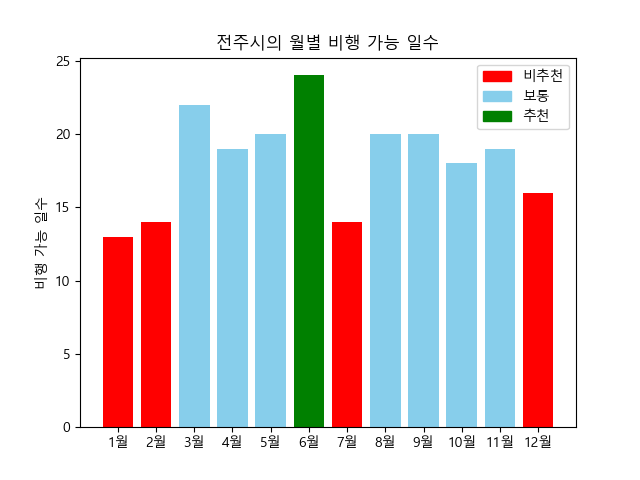
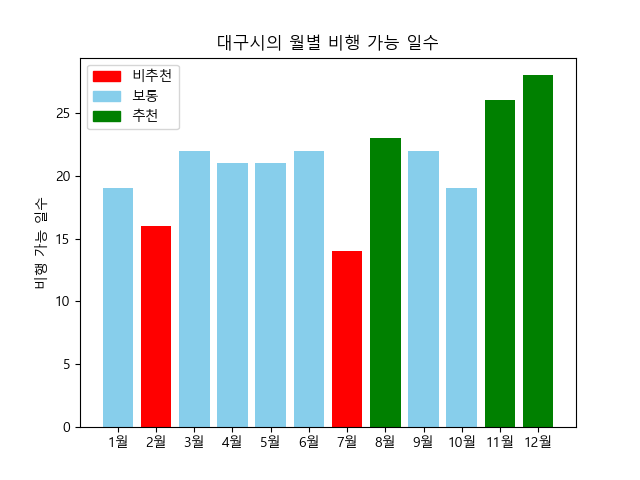
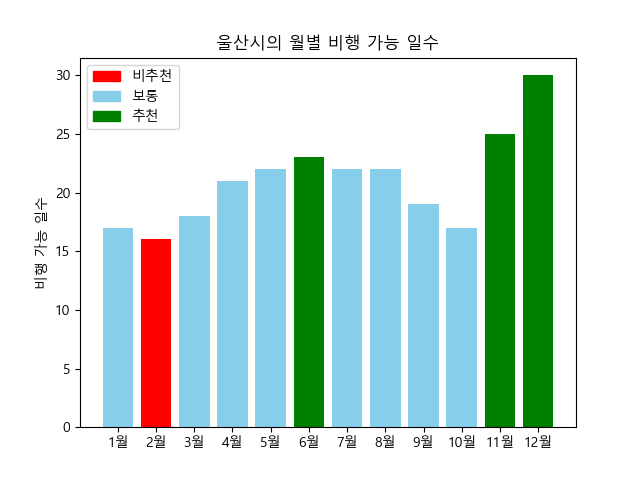
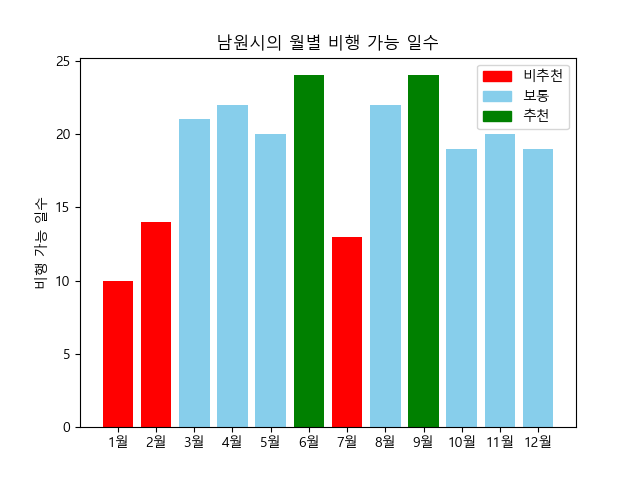
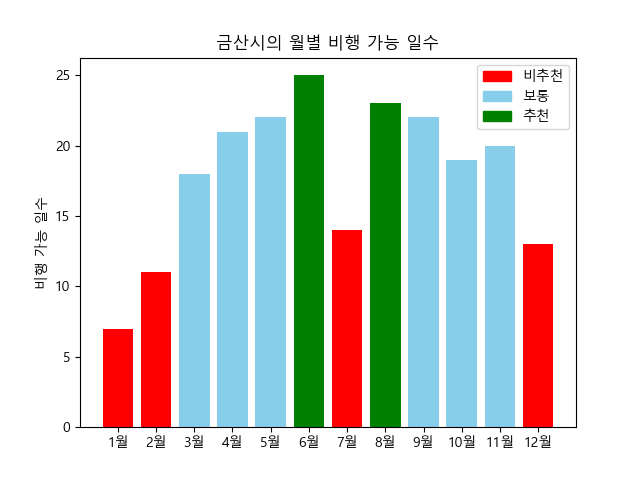
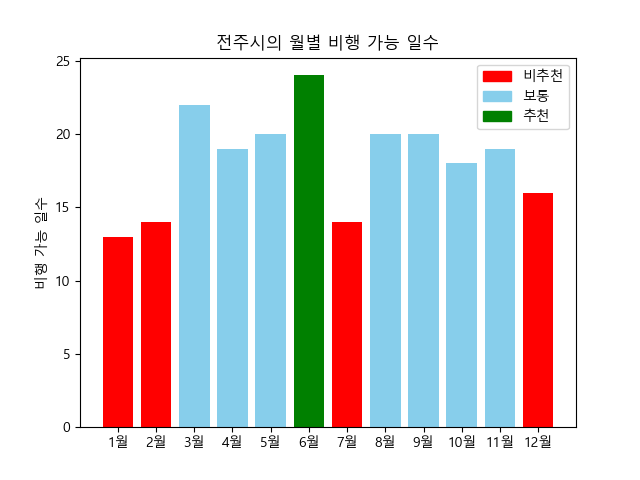
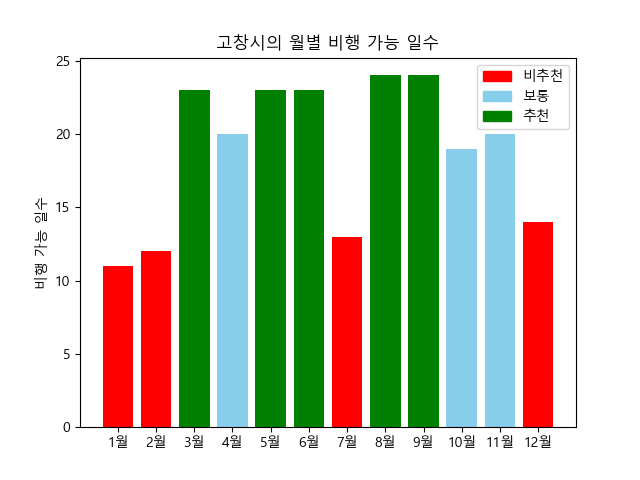
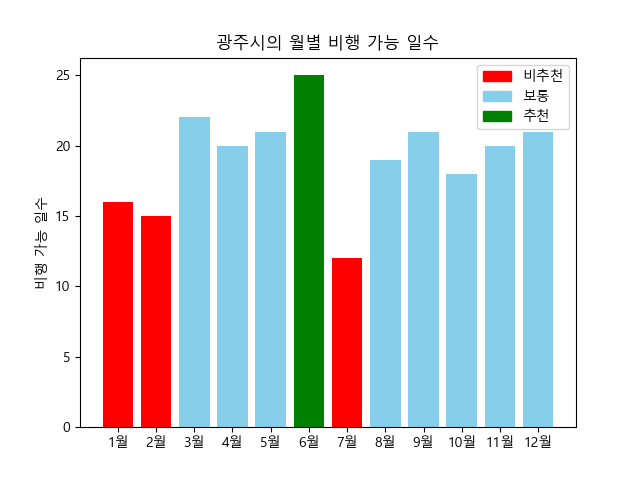
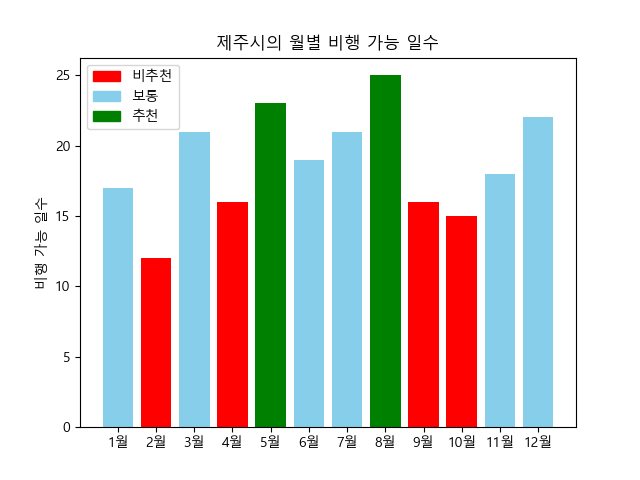
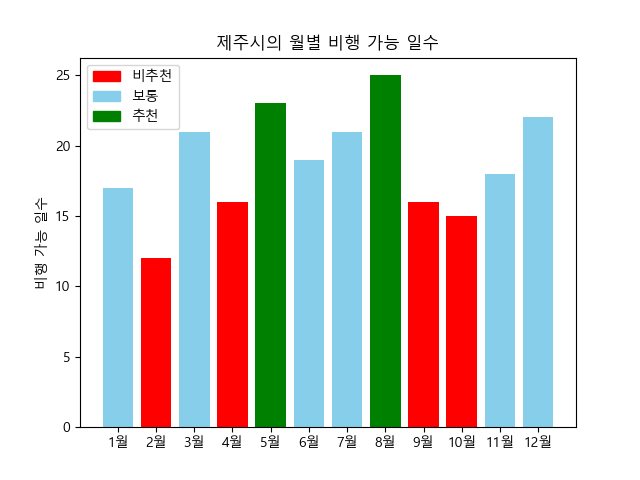
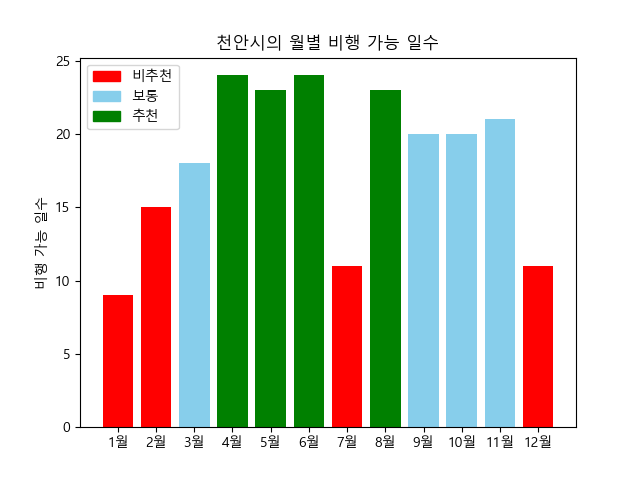
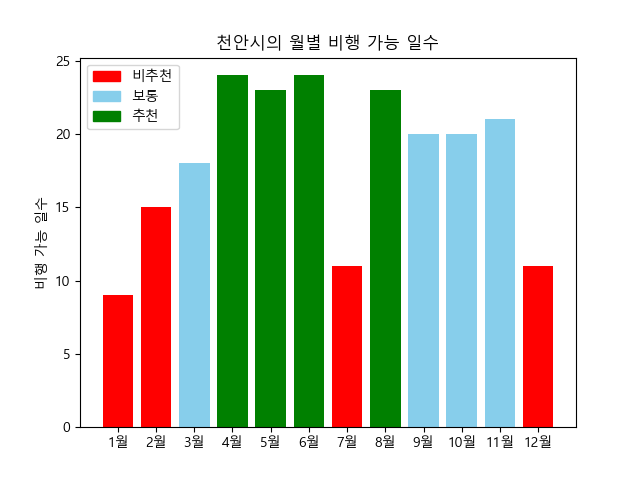
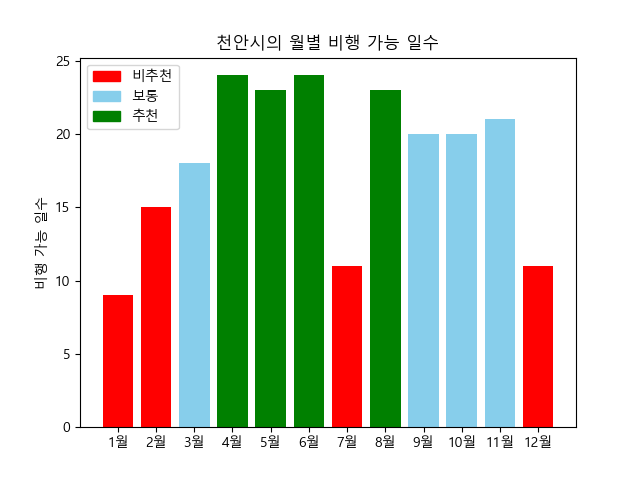
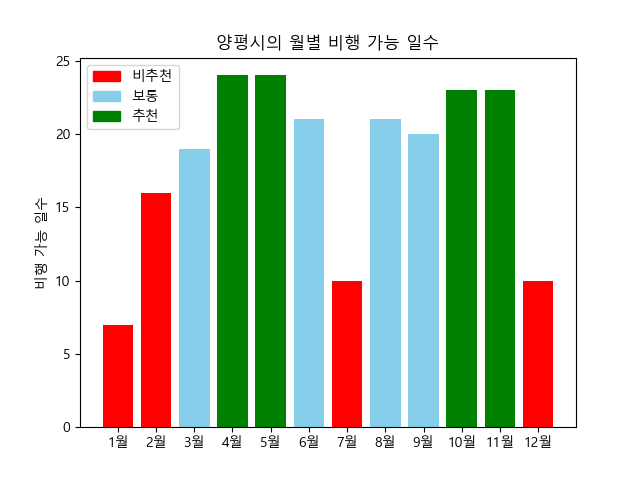
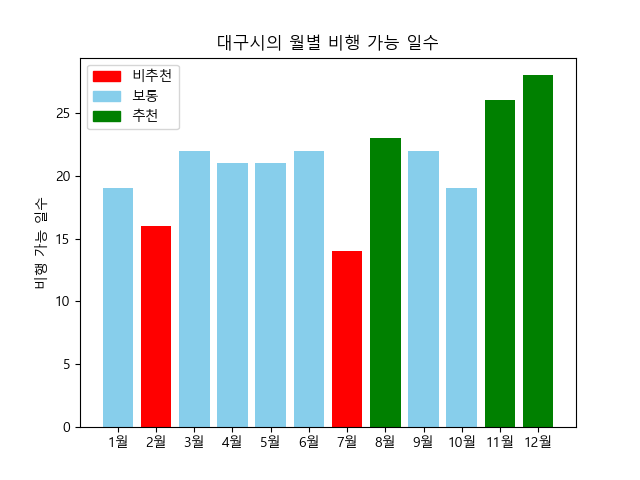
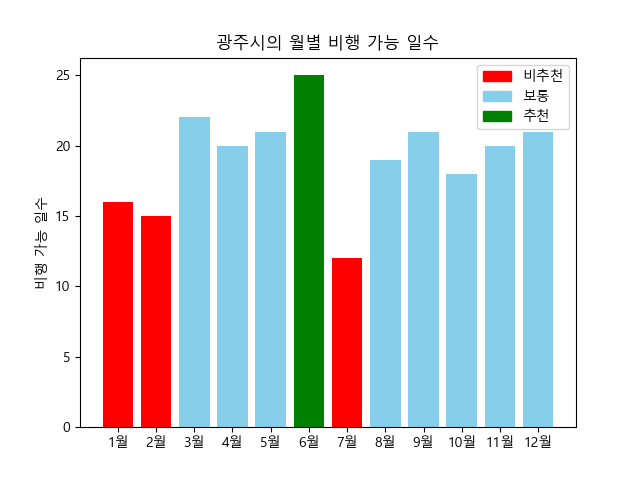
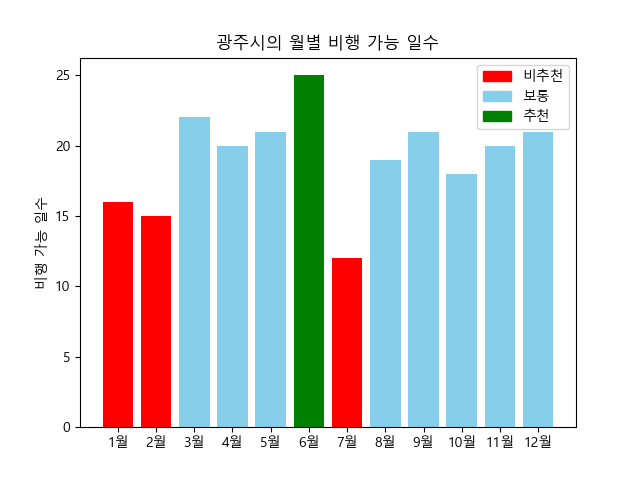
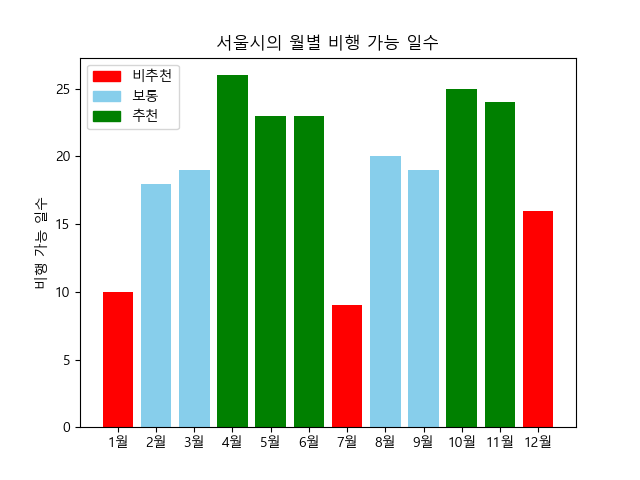
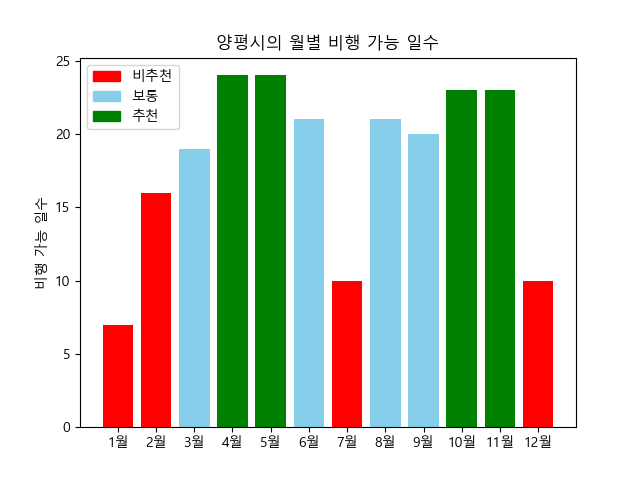
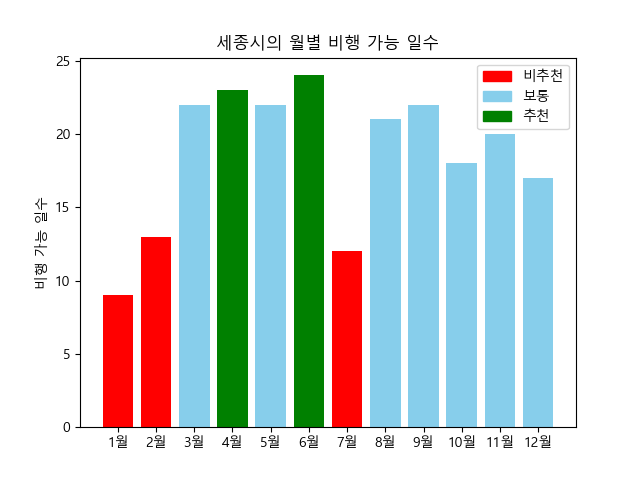
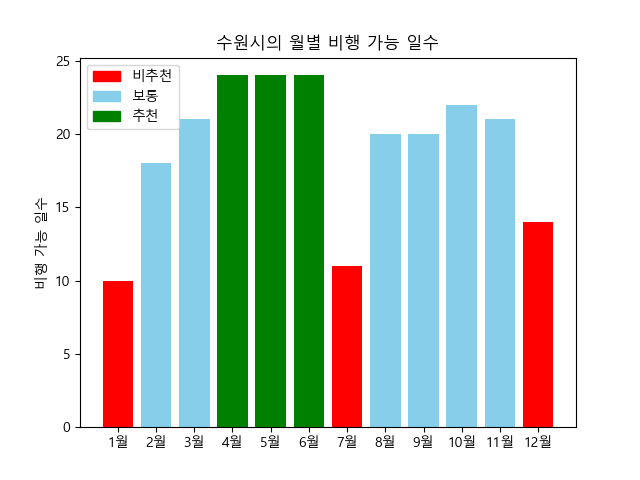
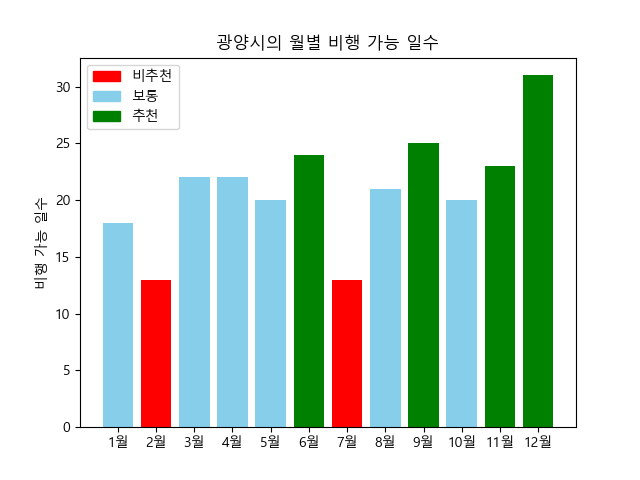
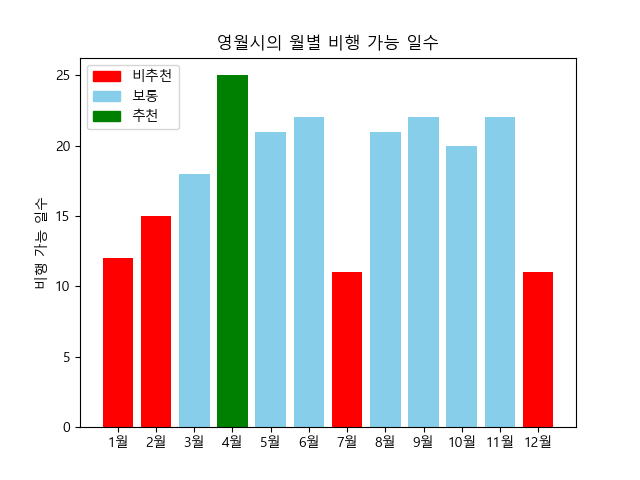
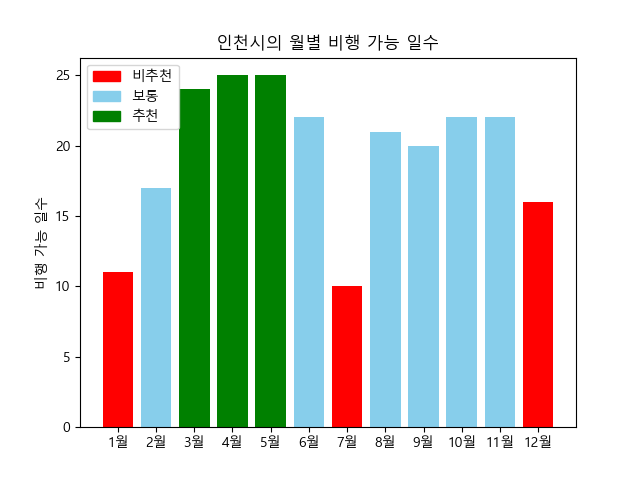
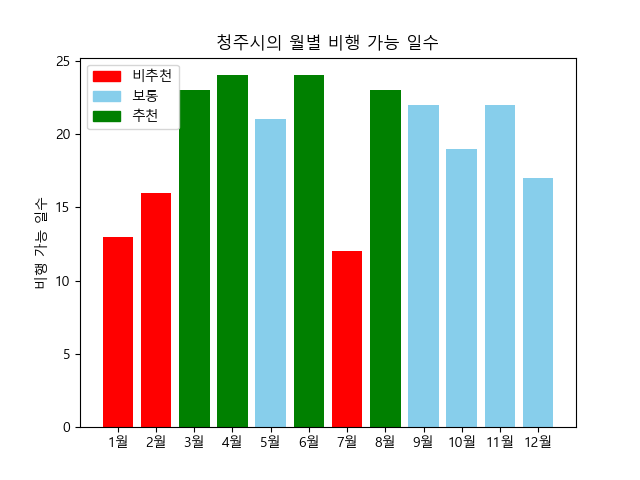
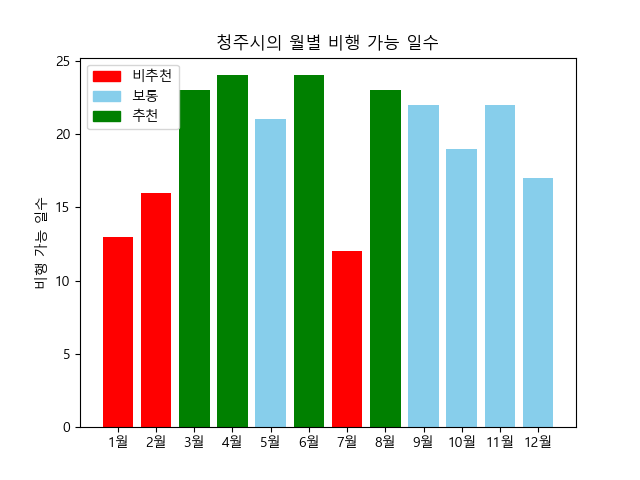
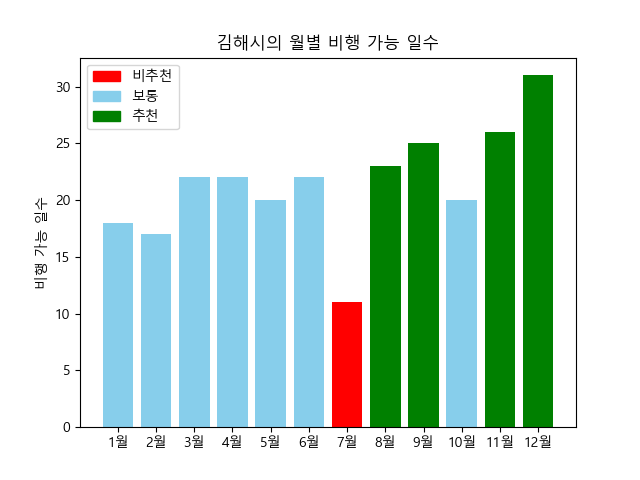
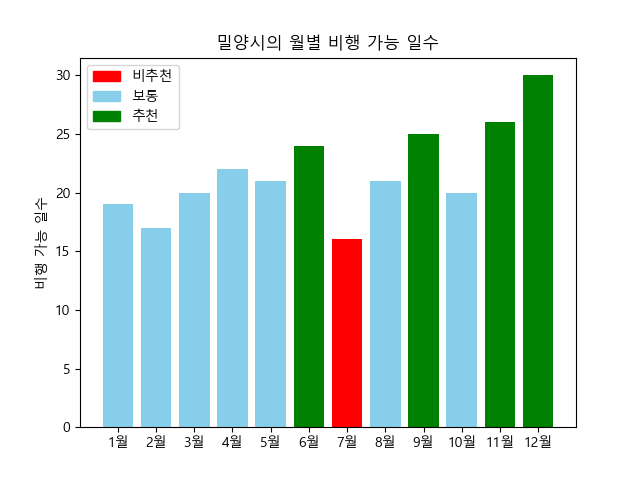
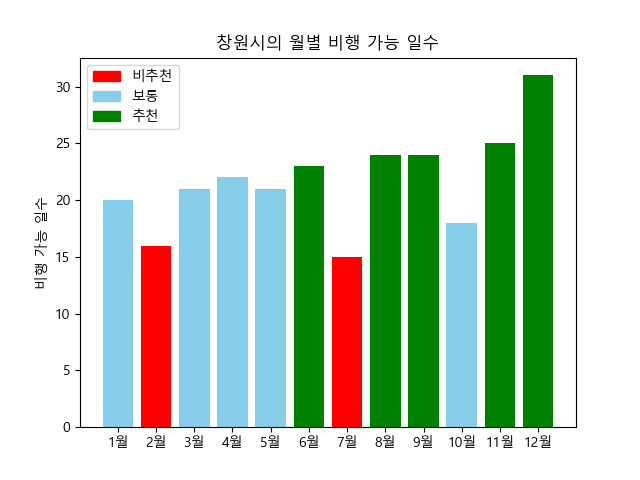
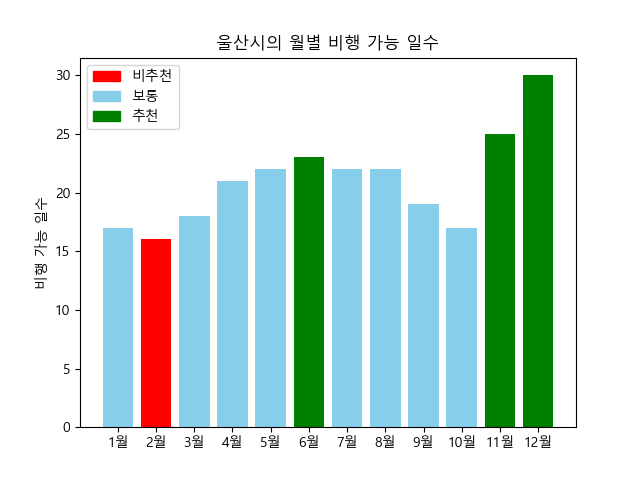
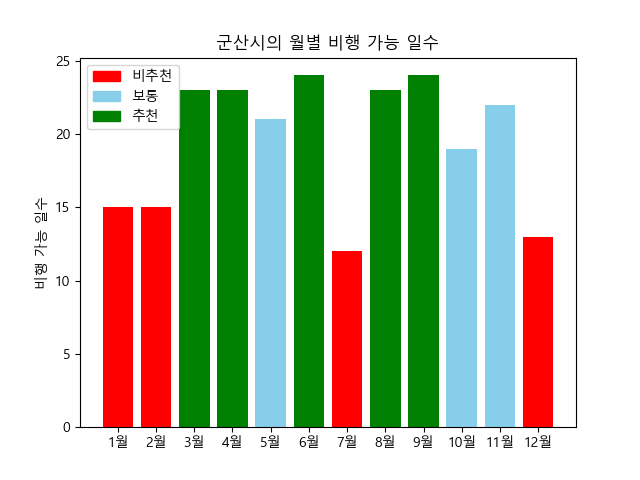
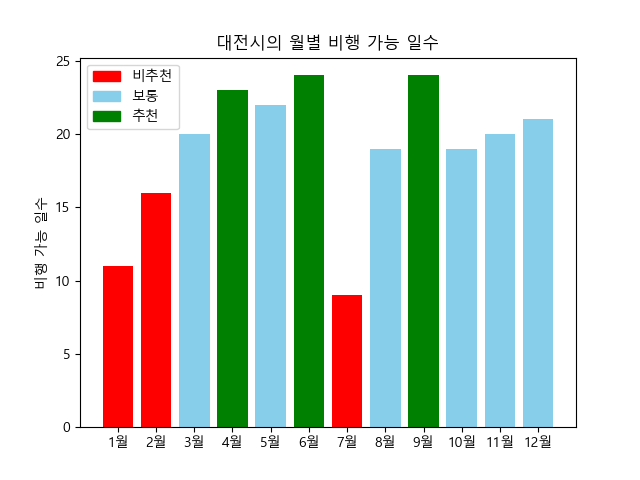
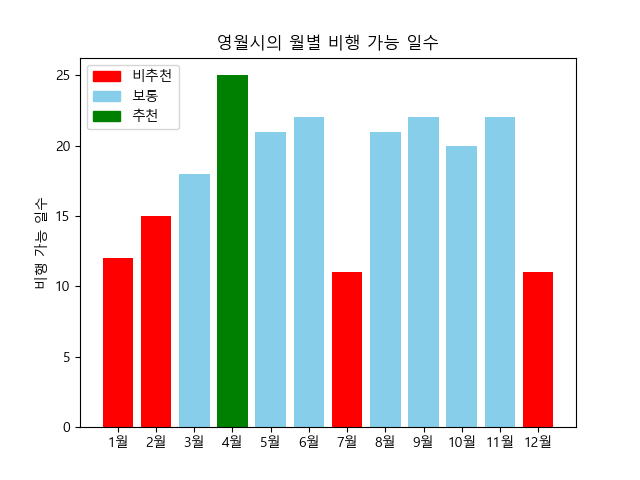
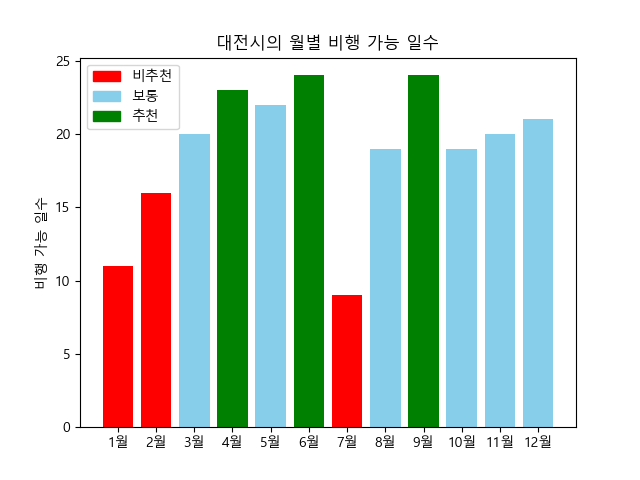
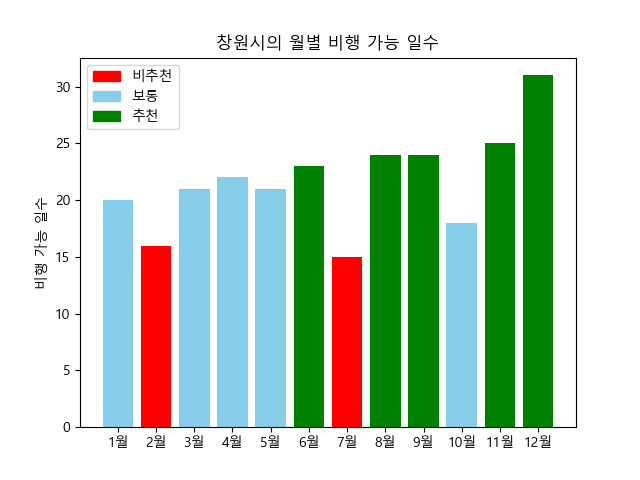
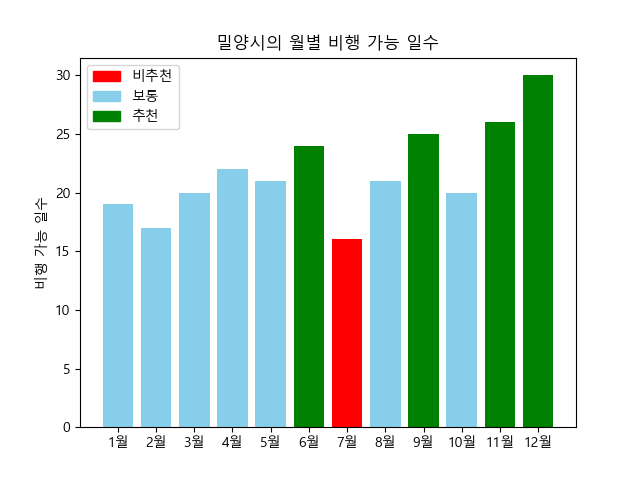
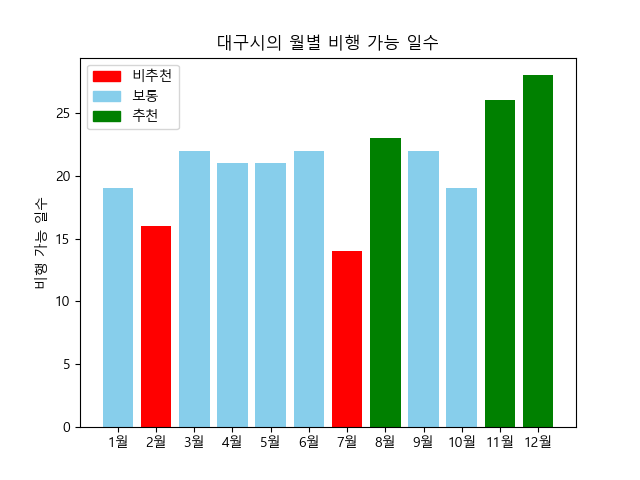
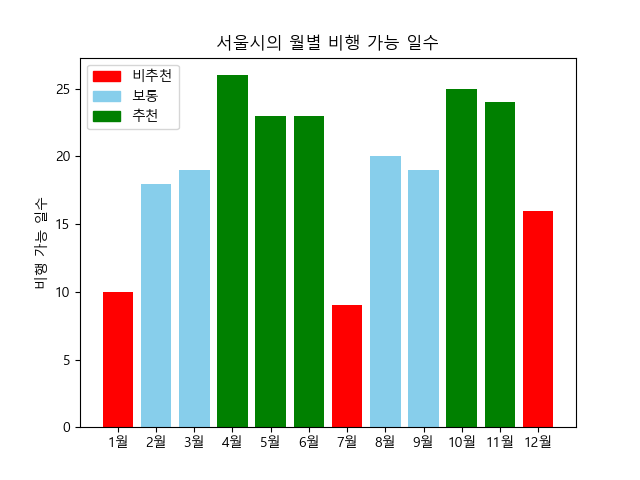
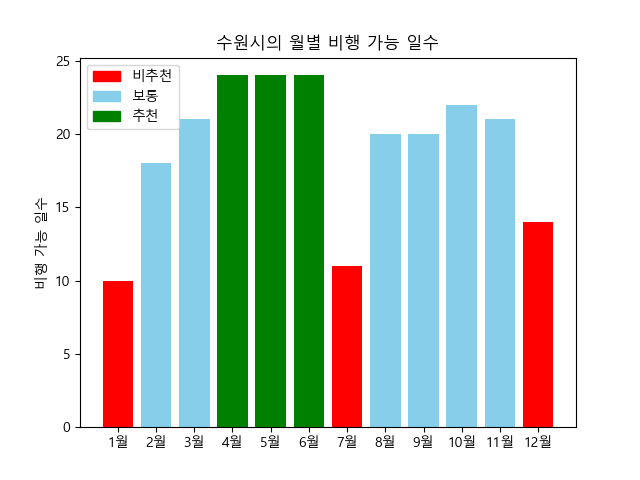
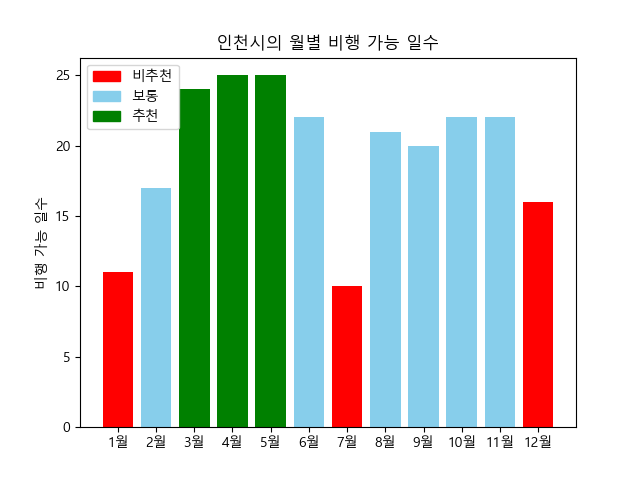
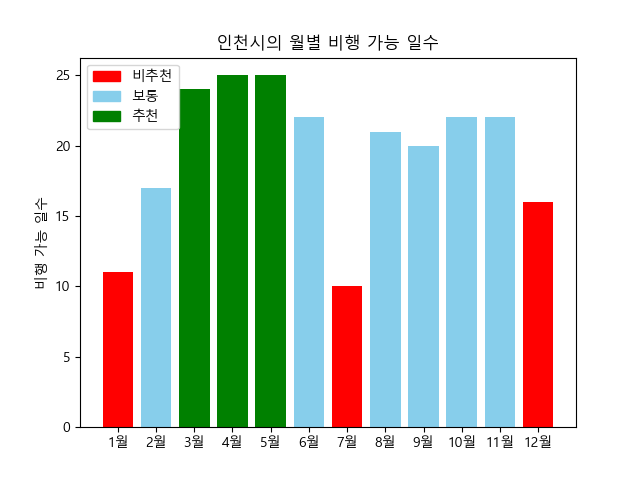
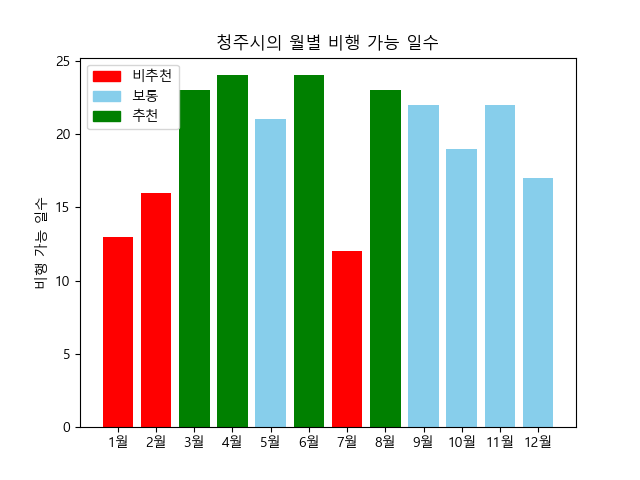
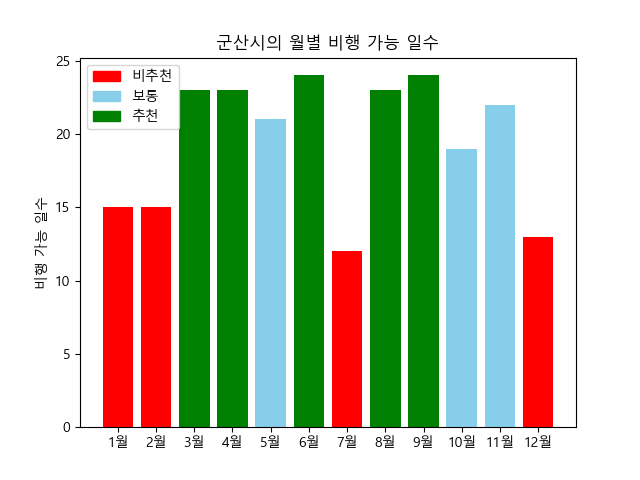
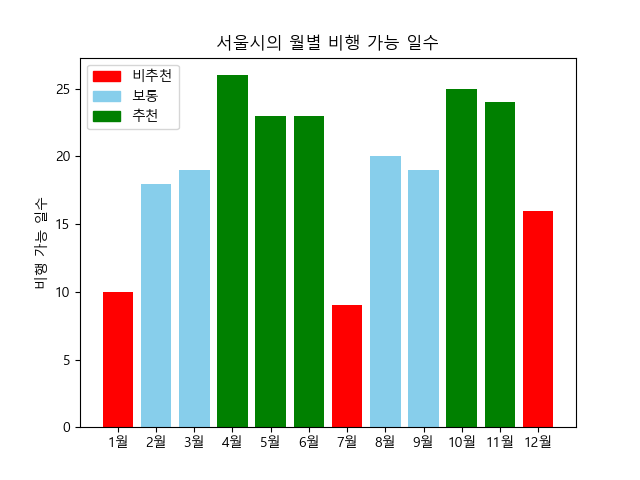
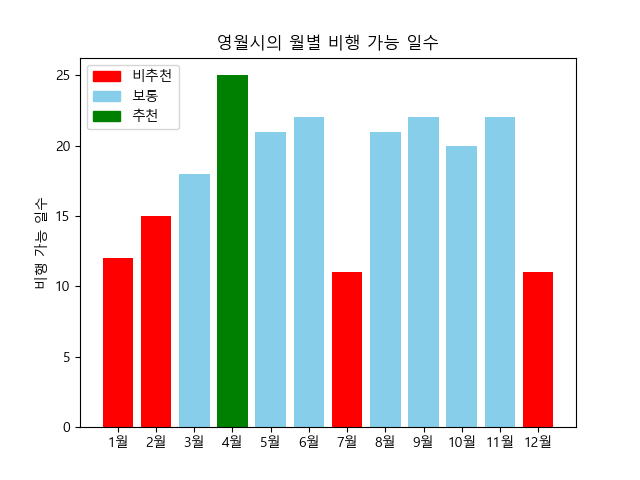
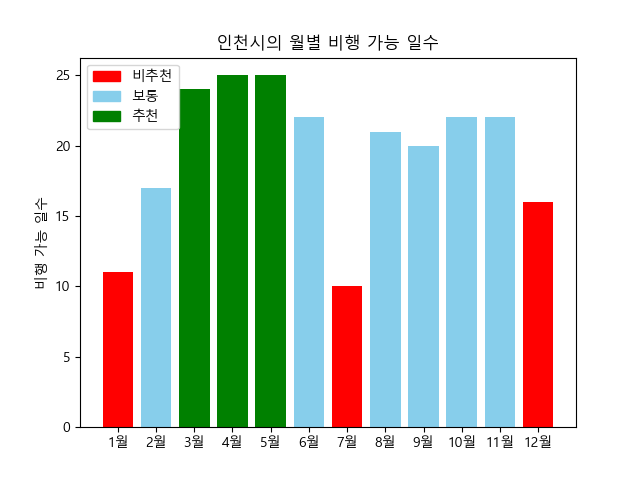
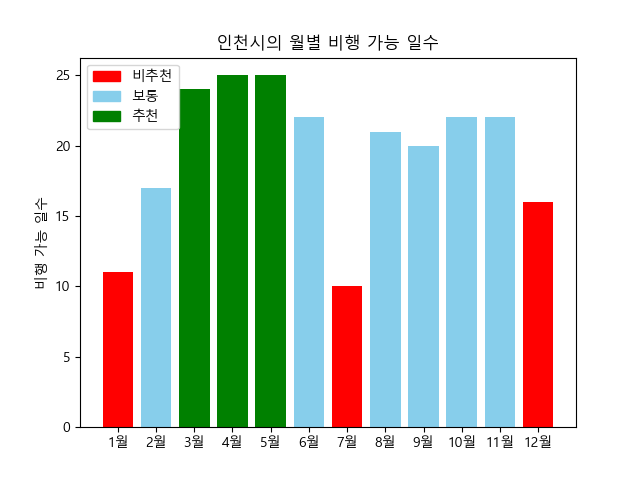
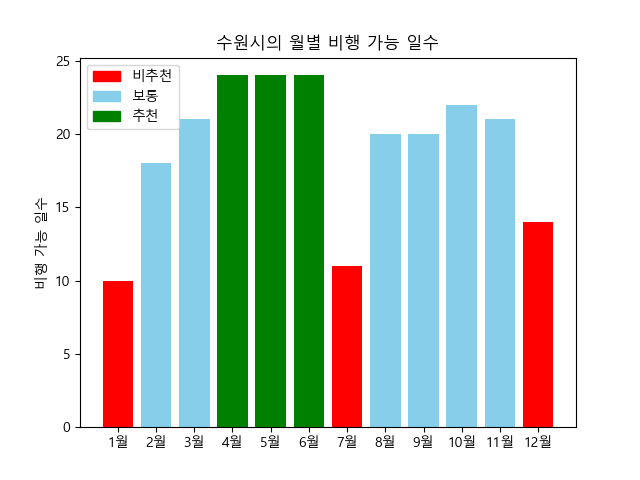
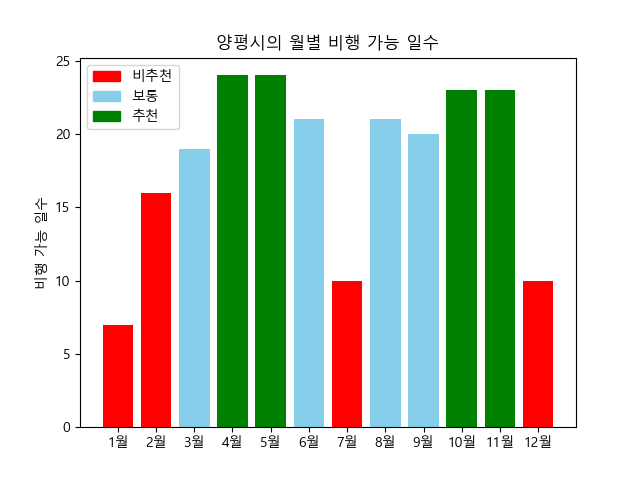
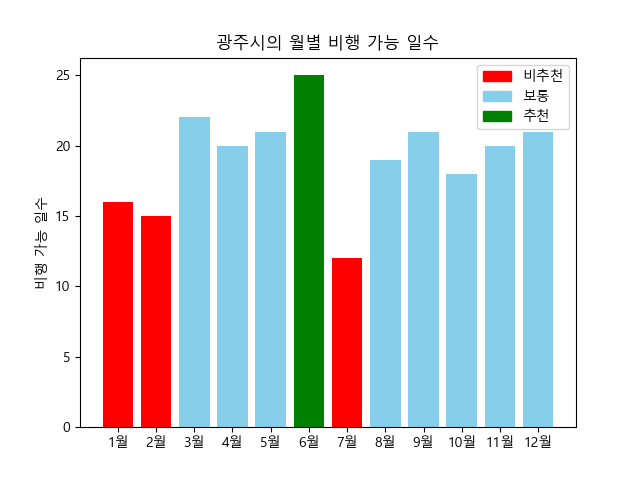
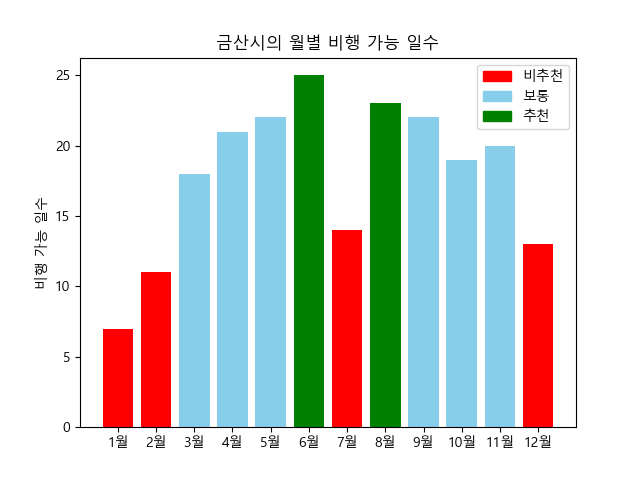
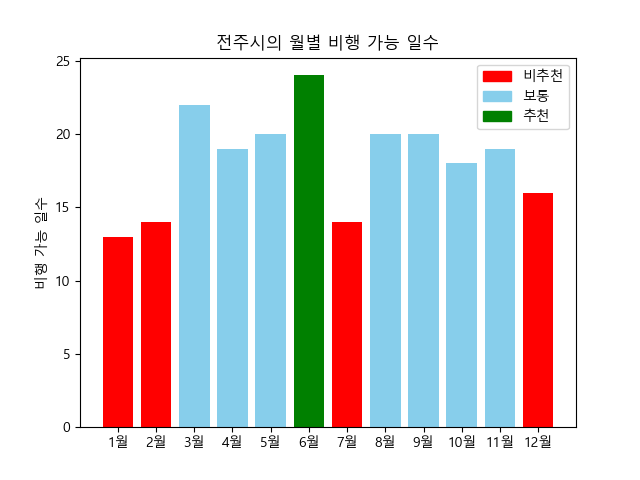
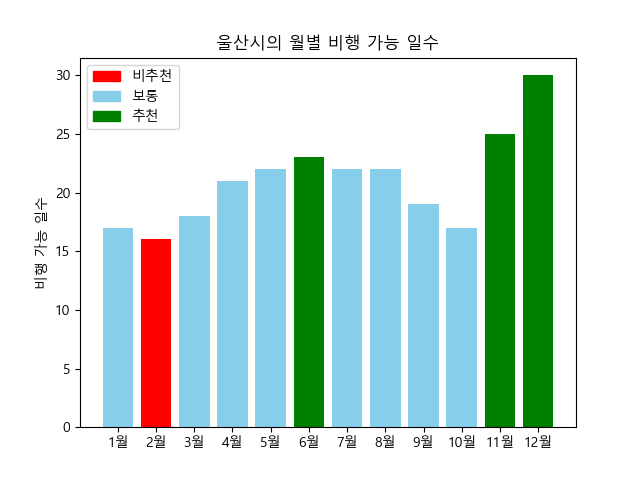
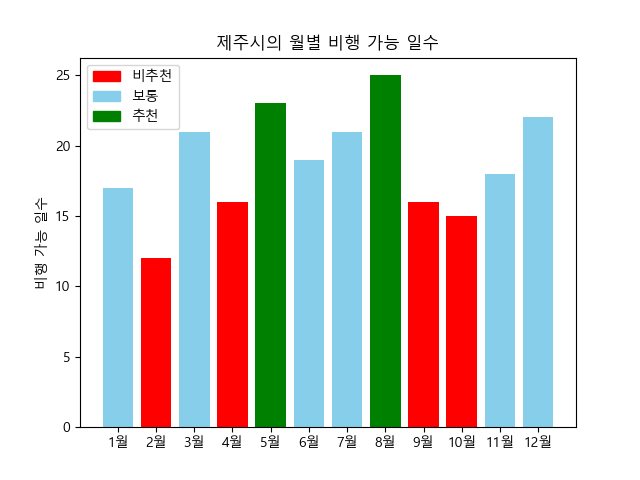
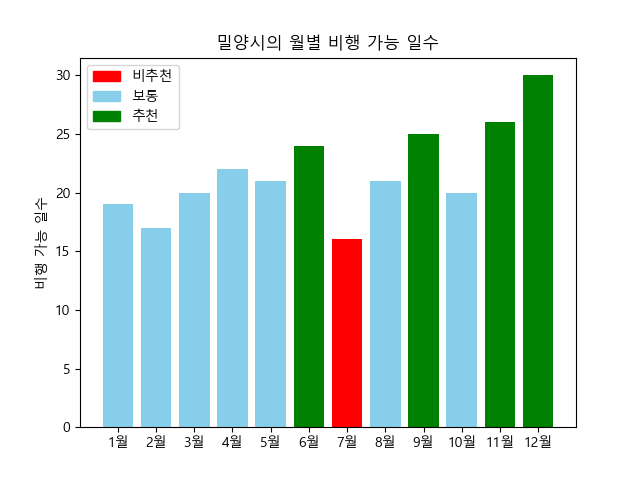
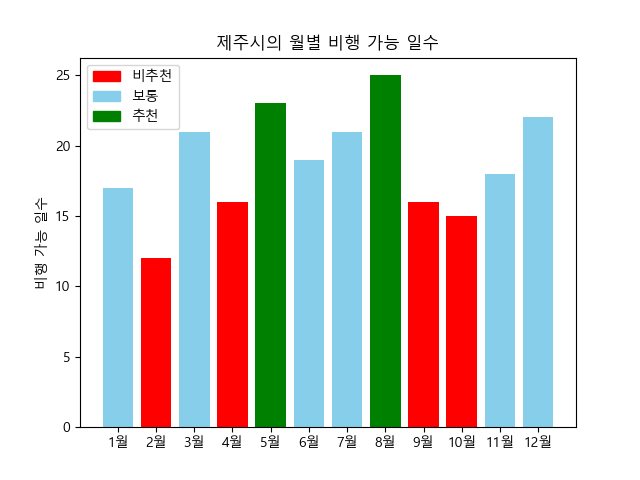
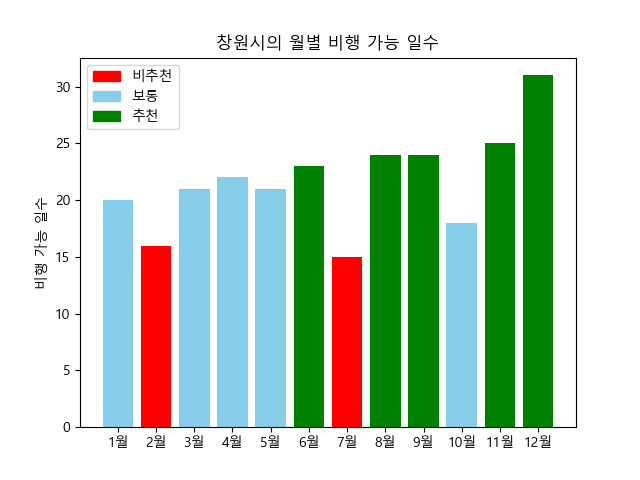
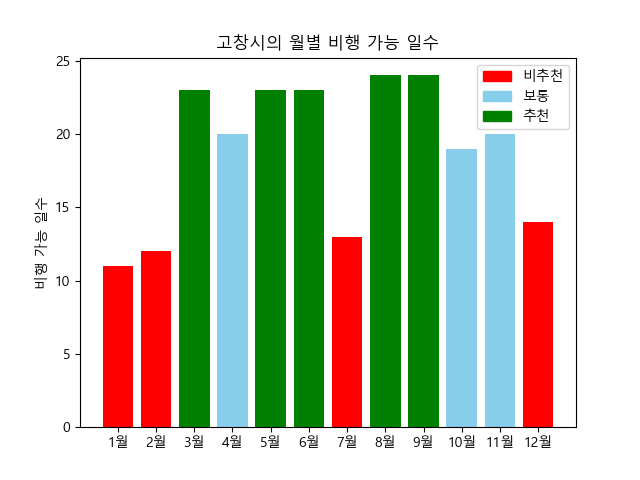
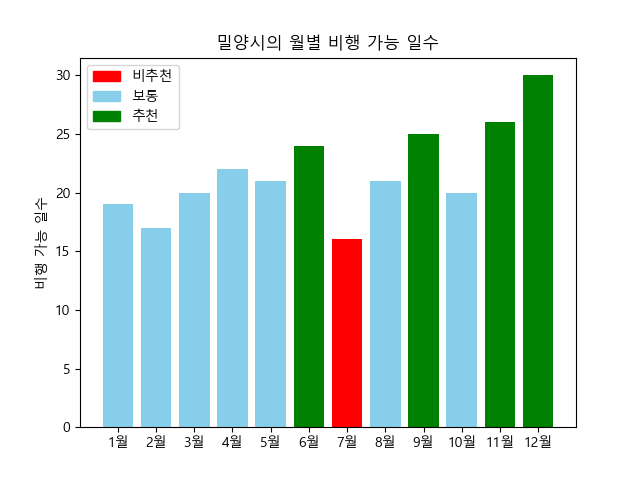
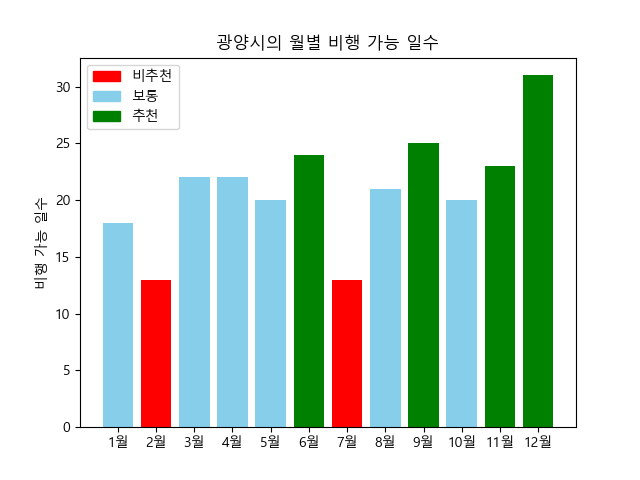
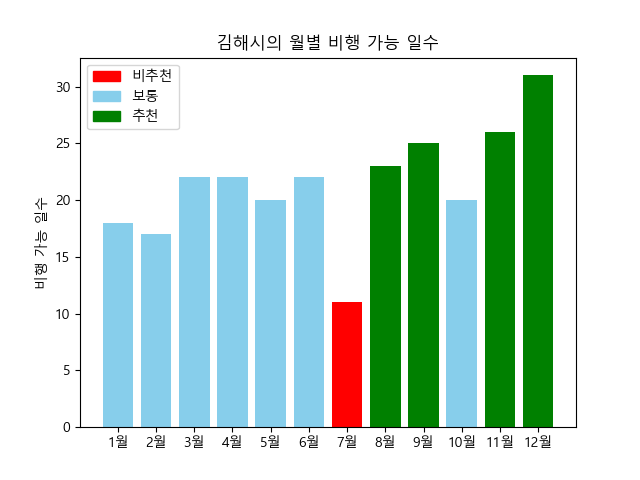
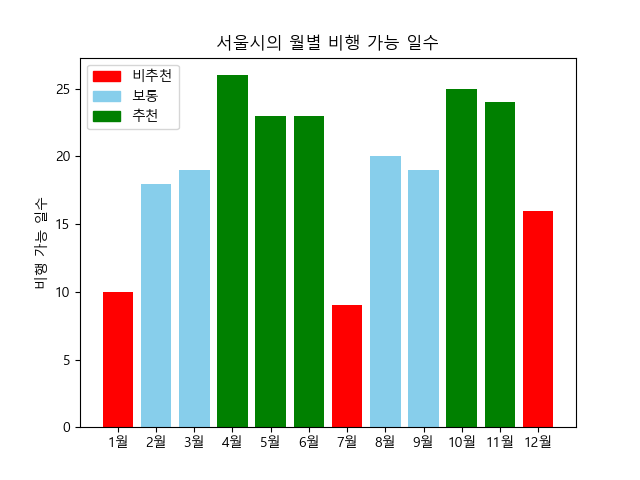
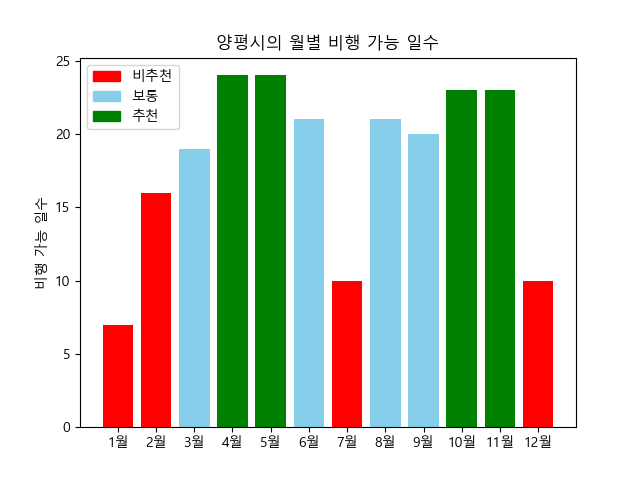
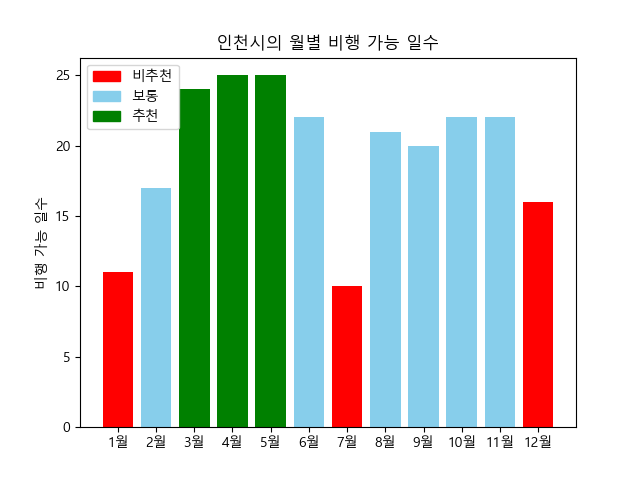
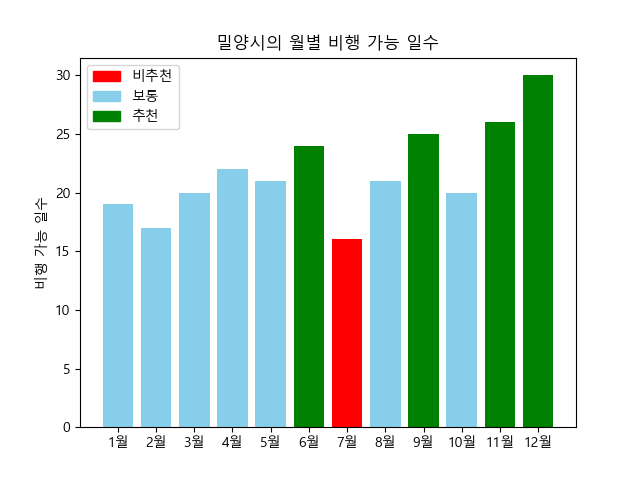
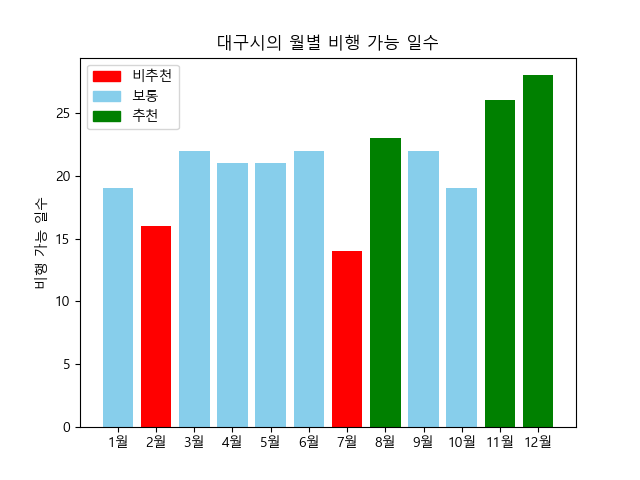
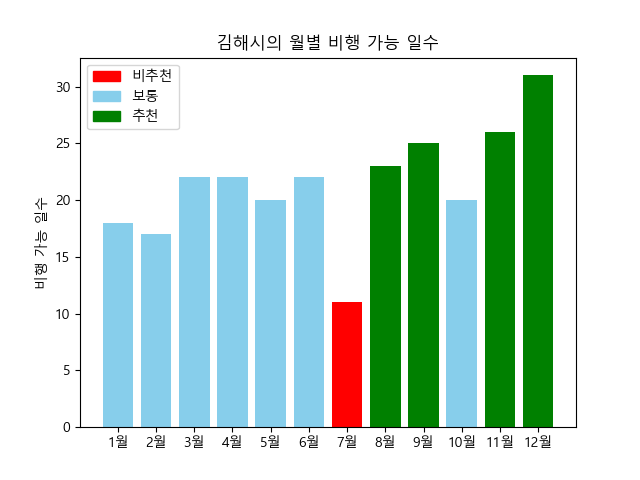
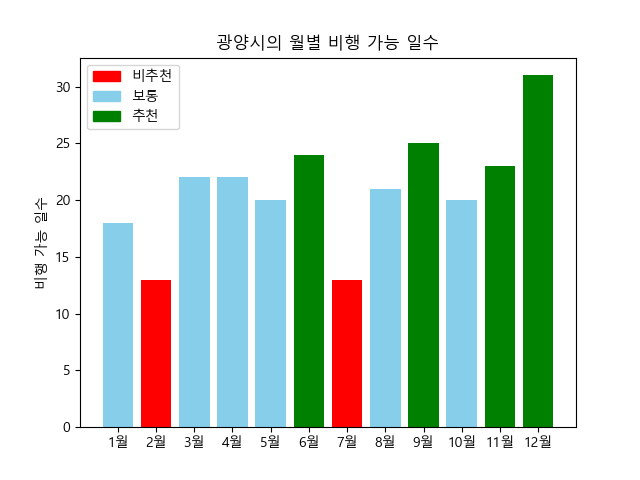
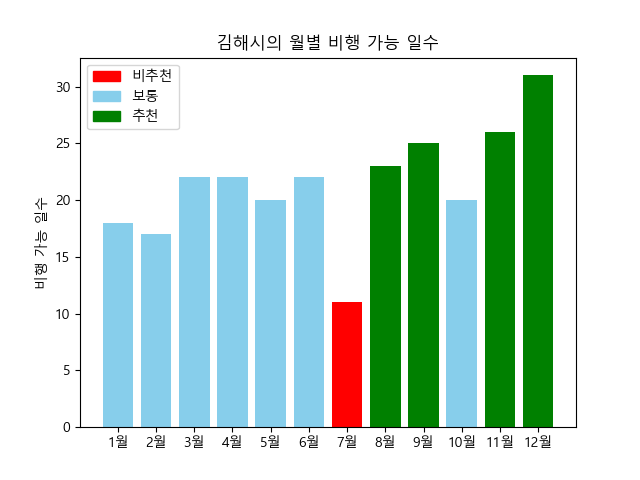
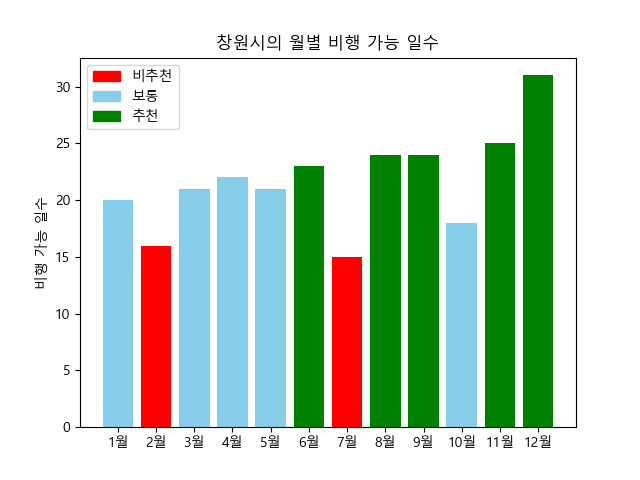

In [60]:
m.save("combined_drone_map.html")
m